In [1]:
import numpy as np
import pylab as plt
from matplotlib import pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

(35.0, 50.0)

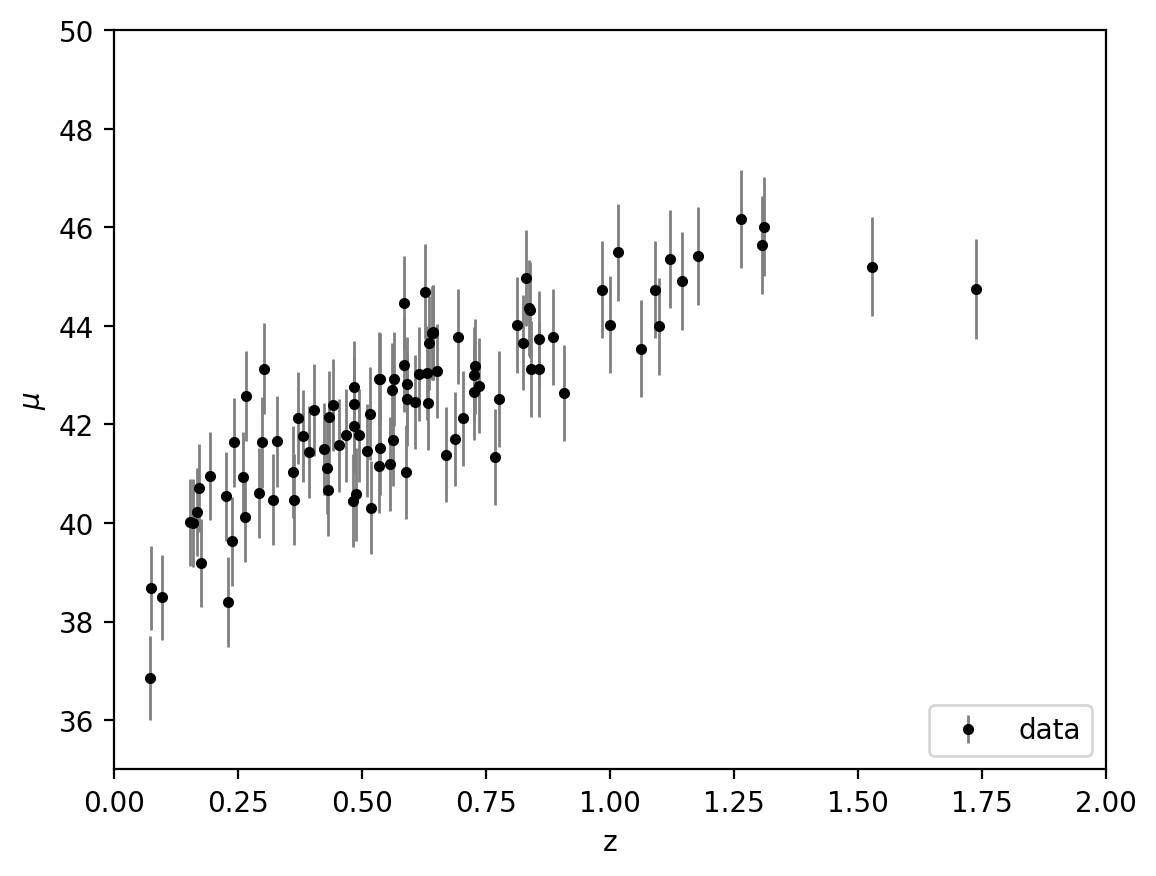

In [2]:
from astroML.datasets import generate_mu_z
z_sample, mu_sample, dmu = generate_mu_z(100, random_state=1234)

plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1,label='data')
plt.xlabel("z")
plt.ylabel("$\mu$")
plt.legend(loc='lower right')
plt.xlim(0,2)
plt.ylim(35,50)

# Linear regression

In [3]:
from sklearn.linear_model import LinearRegression

X_new = np.array([[0], [2]])

lin_reg = LinearRegression()
lin_reg.fit(z_sample.reshape(-1,1),  mu_sample.reshape(-1,1), sample_weight=(1/(dmu**2)))

theta0 = lin_reg.intercept_
theta1 = lin_reg.coef_

print(theta0, theta1)
y_pred_lin = lin_reg.predict(X_new)

[39.48384602] [[4.76438865]]


(35.0, 50.0)

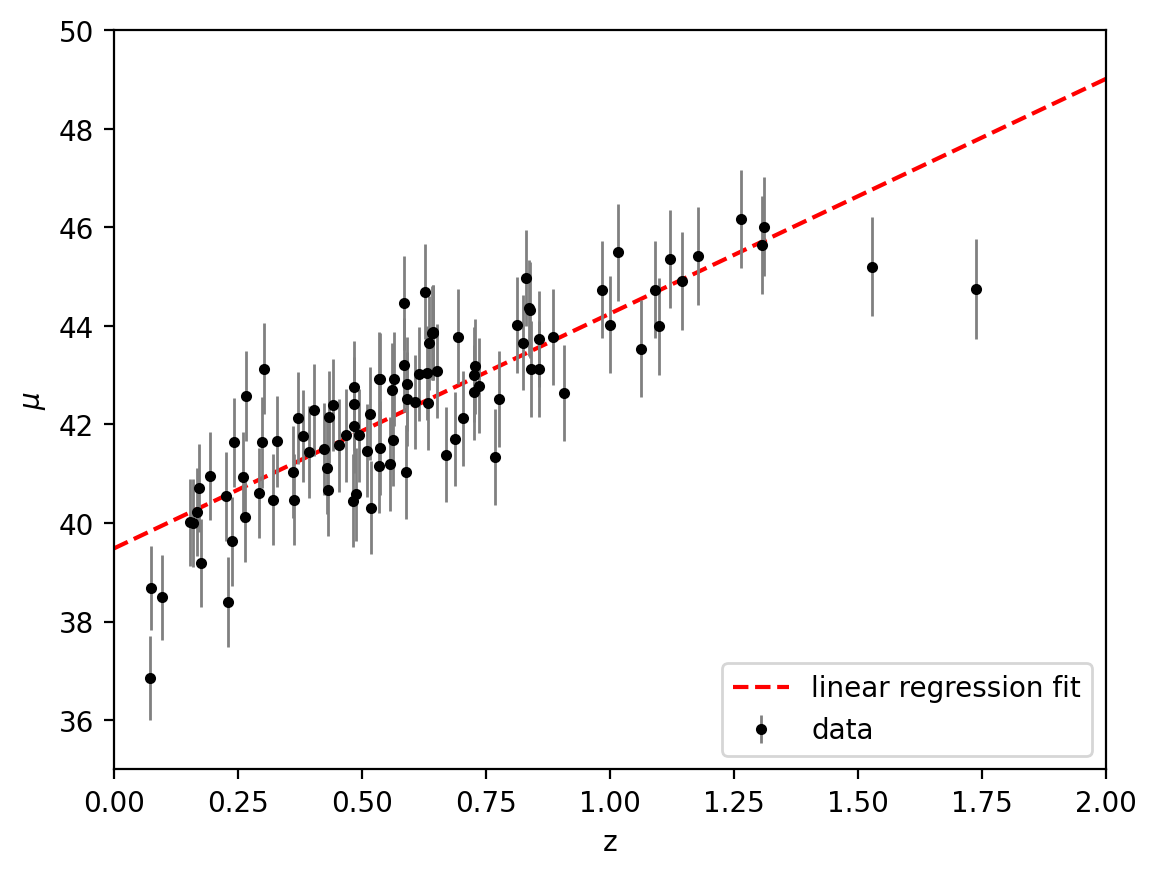

In [4]:
plt.plot(X_new, y_pred_lin, '--r', label = 'linear regression fit')
plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1,label = 'data')
plt.xlabel("z")
plt.ylabel("$\mu$")
plt.legend(loc='lower right')
plt.xlim(0,2)
plt.ylim(35,50)

# Polynomial regression

In [5]:
from astroML.linear_model import PolynomialRegression

degree = 3
model = PolynomialRegression(degree) # fit 3rd degree polynomial
model.fit(z_sample.reshape(-1,1),  mu_sample)

y_pred_poly = model.predict(z_sample.reshape(-1,1))
n_constraints = degree + 1

print(model.coef_)

[38.49130243  8.23905057 -2.20391808 -0.15168104]


C:\Users\Admin\anaconda3\envs\pymc_env\Lib\site-packages\astroML\linear_model\linear_regression_errors.py:10: UserWarning: LinearRegressionwithErrors requires PyMC3 to be installed
  warnings.warn('LinearRegressionwithErrors requires PyMC3 to be installed')


(35.0, 50.0)

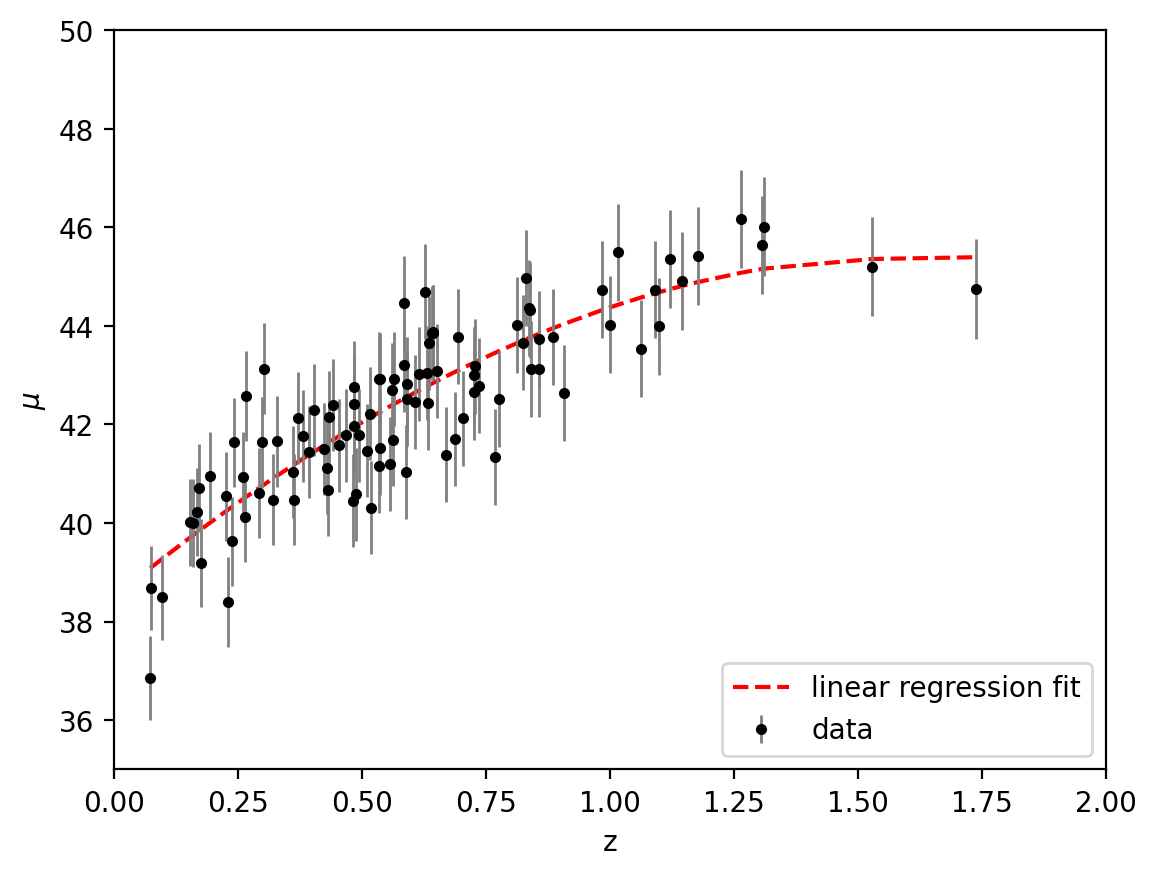

In [6]:
plt.plot(np.sort(z_sample), np.sort(y_pred_poly), '--r', label = 'linear regression fit')
plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1,label = 'data')
plt.xlabel("z")
plt.ylabel("$\mu$")
plt.legend(loc='lower right')
plt.xlim(0,2)
plt.ylim(35,50)

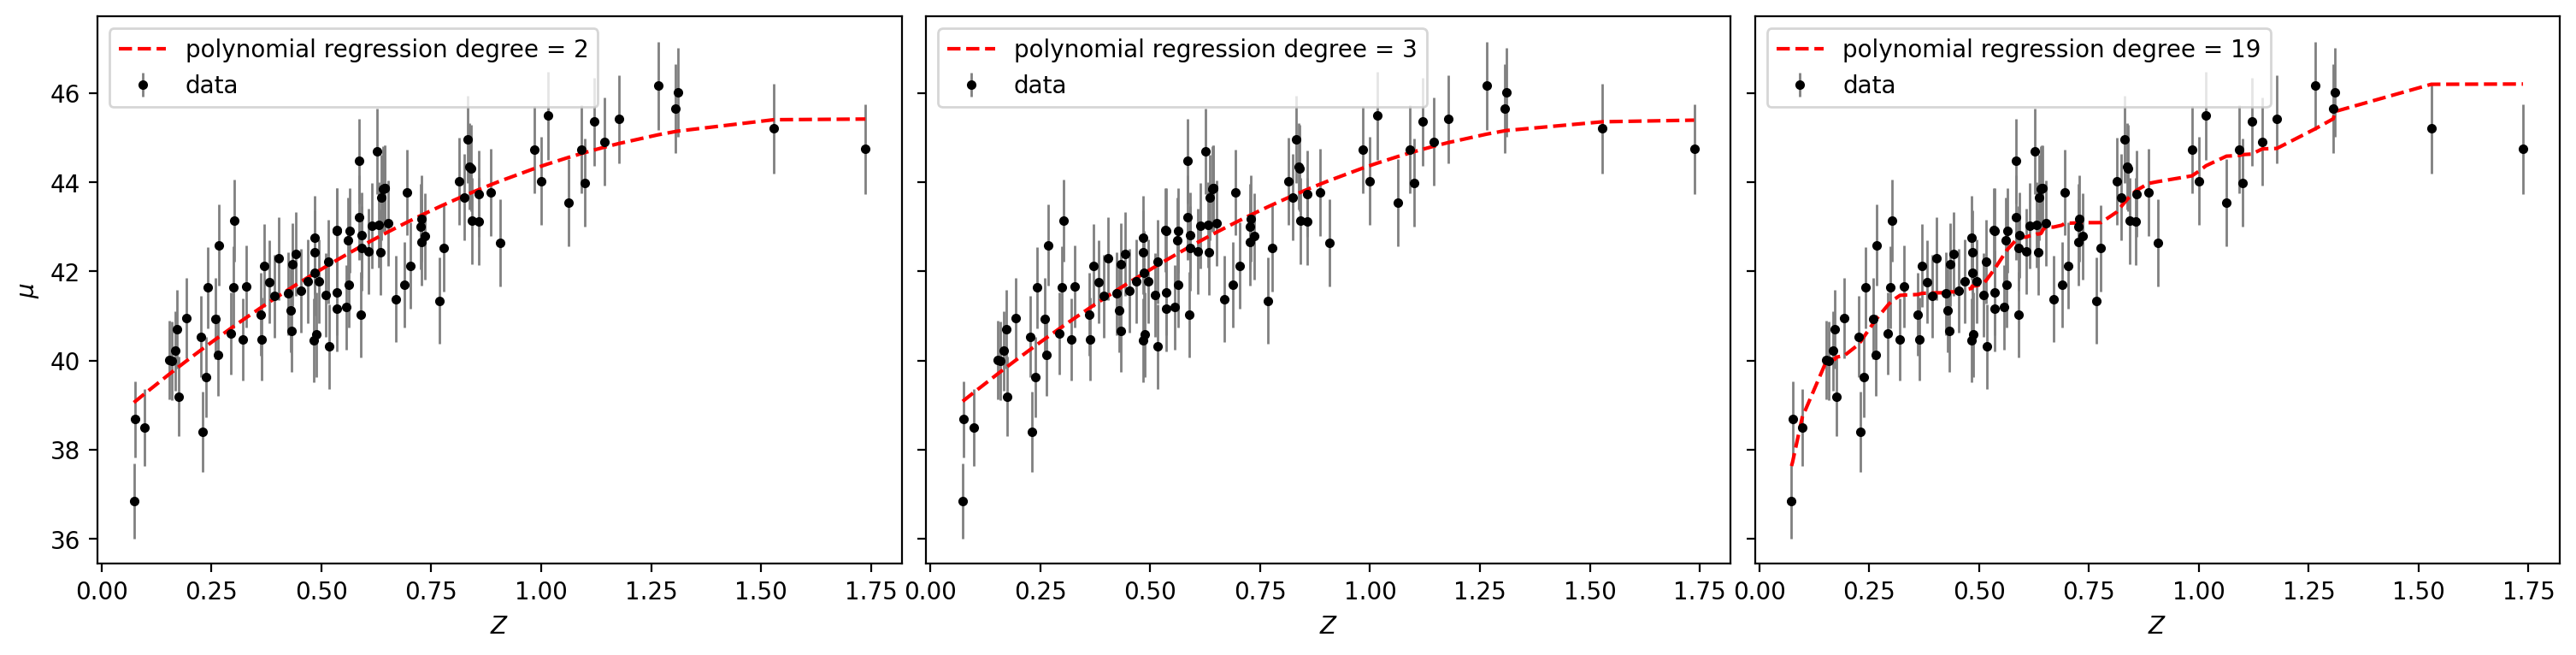

In [7]:
fig = plt.figure(figsize=(16, 4))
fig.subplots_adjust(wspace=0.03, bottom=0.15,
                    top=0.95, left=0.07, right=0.97)

for i, degree in enumerate([2, 3, 19]):  #Try 2nd, 3rd and 19th order
    ax = fig.add_subplot(131 + i)
    ax.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1,label = 'data')

    model = PolynomialRegression(degree) # fit 3rd degree polynomial
    model.fit(z_sample.reshape(-1,1),  mu_sample)

    y_pred_poly = model.predict(z_sample.reshape(-1,1))

    ax.plot(np.sort(z_sample), np.sort(y_pred_poly), '--r', label = 'polynomial regression degree = '+ str(degree))
    
    if i in (1, 2):
        ax.yaxis.set_major_formatter(plt.NullFormatter())
    else:
        ax.set_ylabel('$\mu$')
    ax.set_xlabel('$Z$')
    ax.legend()
    
plt.show()


In [8]:
z_shuffle = z_sample.copy()
mu_shuffle = mu_sample.copy()
np.random.shuffle(z_shuffle)
np.random.shuffle(mu_shuffle)

# Training points
np.random.seed(0)
idx_train = np.random.choice(np.arange(100), size = int(0.7 * len(z_sample)), replace = False)
z_train = np.array([z_shuffle[i] for i in idx_train])
mu_train = np.array([mu_shuffle[i] for i in idx_train])

# Select the cross-validation points
np.random.seed(1)
idx_cv = np.random.choice(np.arange(100), size = int(0.7 * len(z_sample)), replace = False)
z_cv = np.array([z_shuffle[i] for i in idx_cv])
mu_cv = np.array([mu_shuffle[i] for i in idx_cv])

# Third figure: plot errors as a function of polynomial degree d
d = np.arange(0, 21)
training_err = np.zeros(d.shape)
crossval_err = np.zeros(d.shape)

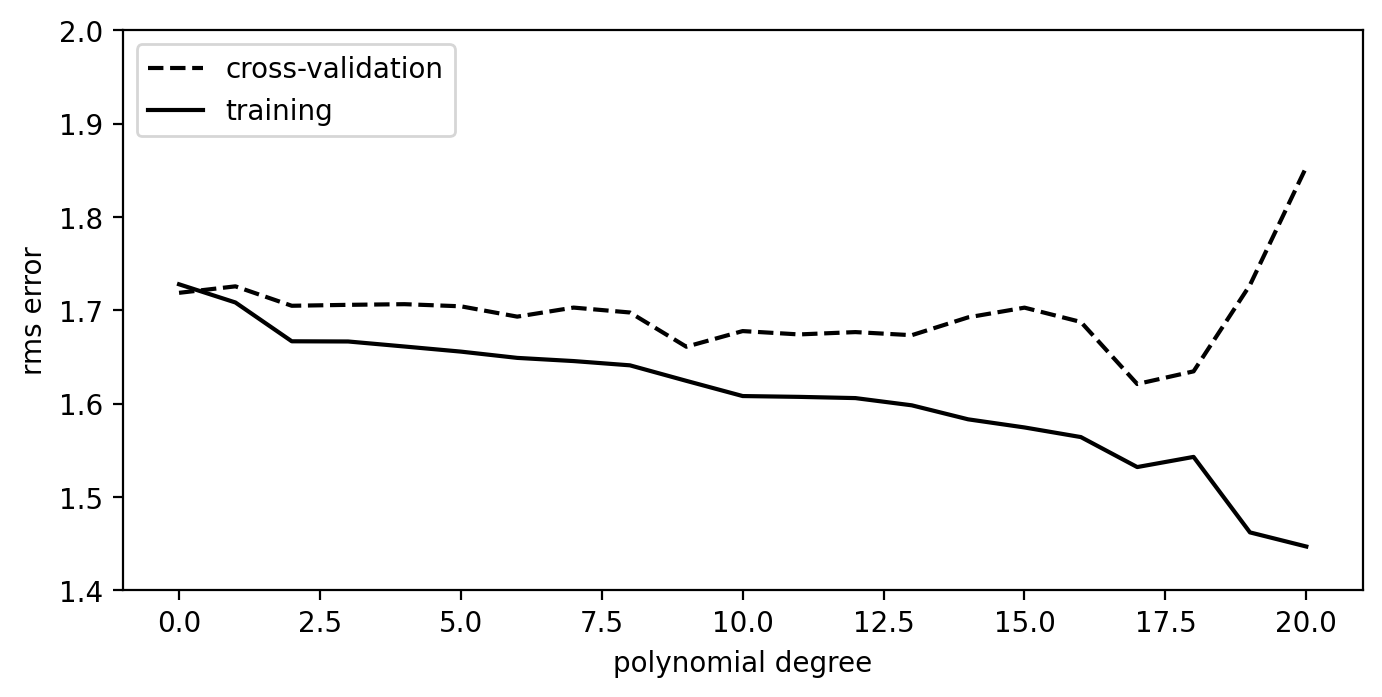

In [9]:
fig = plt.figure(figsize=(8, 8))
for i in range(len(d)):
    
    model = PolynomialRegression(i)
    model.fit(z_train.reshape(-1,1),  mu_train)

    y_train = model.predict(z_train.reshape(-1,1))
    y_cv = model.predict(z_cv.reshape(-1,1))
    
    training_err[i] = np.sqrt(np.sum((y_train - mu_train) ** 2)  / len(mu_train))
    crossval_err[i] = np.sqrt(np.sum((y_cv - mu_cv) ** 2) / len(mu_cv))

ax = fig.add_subplot(211)
ax.plot(d, crossval_err, '--k', label='cross-validation')
ax.plot(d, training_err, '-k', label='training')

ax.set_ylim(1.4,2)
ax.set_xlabel('polynomial degree')
ax.set_ylabel('rms error')
ax.legend(loc=2)

plt.show()

In [10]:
z_shuffle = z_sample.copy()
mu_shuffle = mu_sample.copy()
np.random.shuffle(z_shuffle)
np.random.shuffle(mu_shuffle)
idx = np.arange(100)
np.random.shuffle(idx)

# Training points
z_train = z_shuffle[idx[:70]]
mu_train = mu_shuffle[idx[:70]]

# Select the cross-validation points
z_train = z_shuffle[idx[70:85]]
mu_train = mu_shuffle[idx[70:85]]

# Third figure: plot errors as a function of polynomial degree d
d = np.arange(0, 21)
training_err = np.zeros(d.shape)
crossval_err = np.zeros(d.shape)

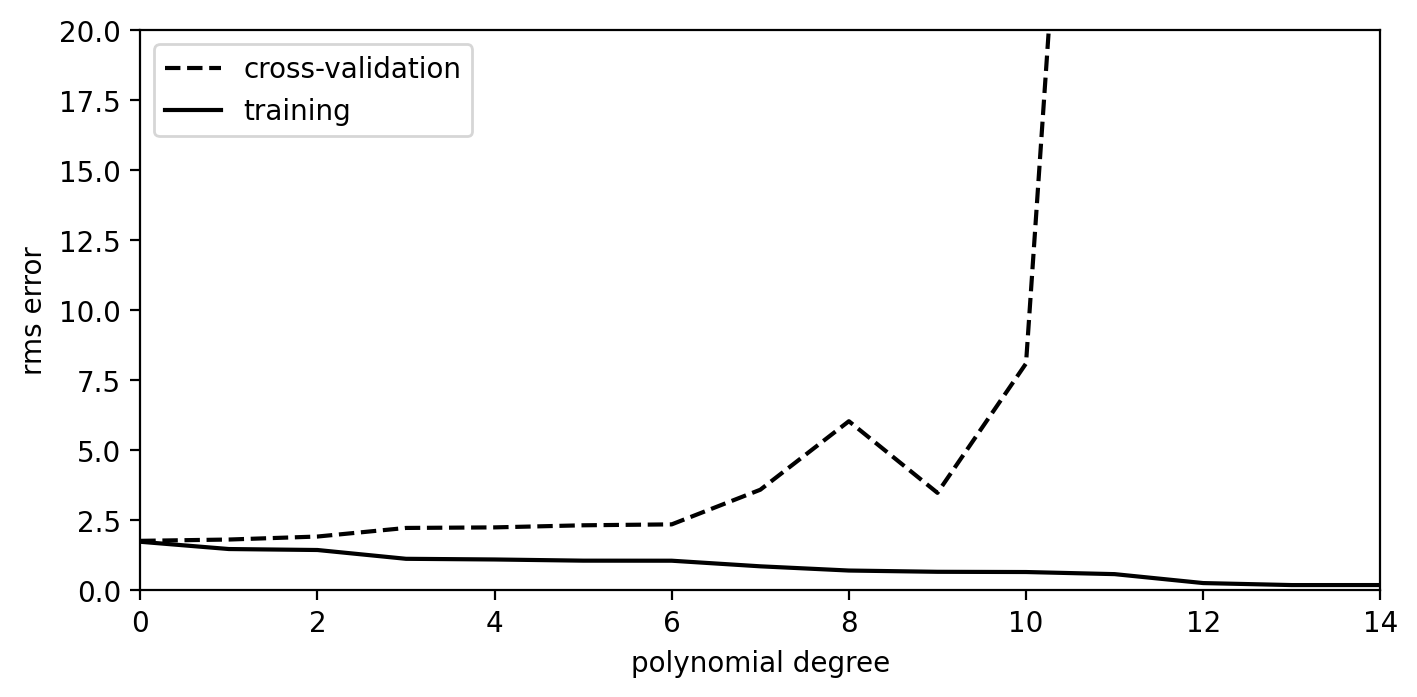

In [11]:
fig = plt.figure(figsize=(8, 8))
for i in range(len(d)):
    
    model = PolynomialRegression(i)
    model.fit(z_train.reshape(-1,1),  mu_train)

    y_train = model.predict(z_train.reshape(-1,1))
    y_cv = model.predict(z_cv.reshape(-1,1))
    
    training_err[i] = np.sqrt(np.sum((y_train - mu_train) ** 2)  / len(mu_train))
    crossval_err[i] = np.sqrt(np.sum((y_cv - mu_cv) ** 2) / len(mu_cv))

ax = fig.add_subplot(211)
ax.plot(d, crossval_err, '--k', label='cross-validation')
ax.plot(d, training_err, '-k', label='training')

ax.set_xlim(0, 14)
ax.set_ylim(0, 20)
ax.set_xlabel('polynomial degree')
ax.set_ylabel('rms error')
ax.legend(loc=2)

plt.show()

In [15]:
#Basis function regression looks like this
from astroML.linear_model import BasisFunctionRegression

# mean positions of the 10 Gaussians in the model
X_gridtest = np.linspace(min(z_sample),max(z_sample),10)[:, None]
# widths of these Gaussians
sigma_test = 0.1

model = BasisFunctionRegression('gaussian', mu=X_gridtest, sigma=sigma_test)
model.fit(z_sample.reshape(-1,1), mu_sample, dmu)

y_pred_basis = model.predict(z_sample.reshape(-1,1))
print(model.coef_)

[20.8016672   3.5091414   3.7469782   3.8019351   4.11376634  4.13199757
  4.36895315  4.47850271  4.80974925  4.31792133  5.21531913]


(35.0, 50.0)

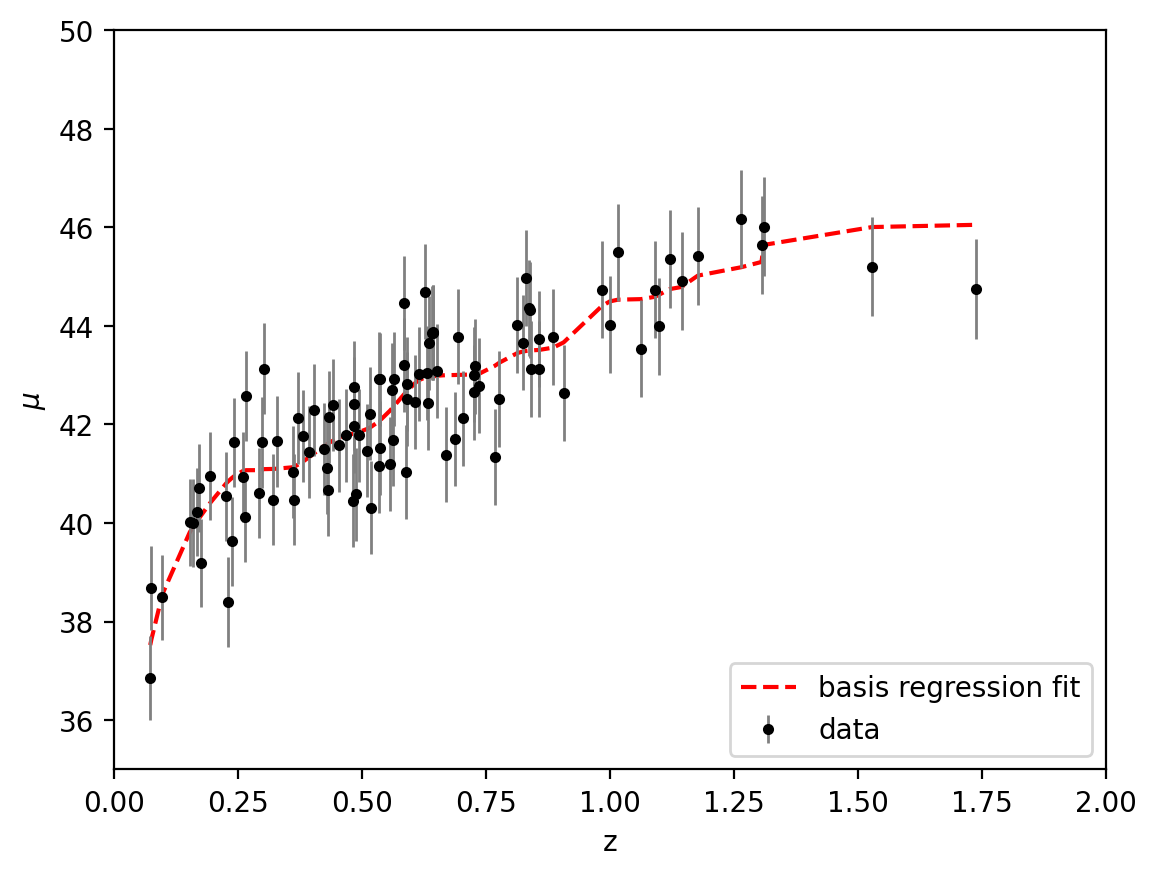

In [16]:
plt.plot(np.sort(z_sample), np.sort(y_pred_basis), '--r', label = 'basis func regression fit')
plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1,label = 'data')
plt.xlabel("z")
plt.ylabel("$\mu$")
plt.legend(loc='lower right')
plt.xlim(0,2)
plt.ylim(35,50)

In [19]:
from astroML.linear_model import NadarayaWatson

model = NadarayaWatson(kernel='gaussian', h=0.05)
model.fit(z_sample.reshape(-1,1),mu_sample)

y_pred_kernel = model.predict(z_sample.reshape(-1,1))

(35.0, 50.0)

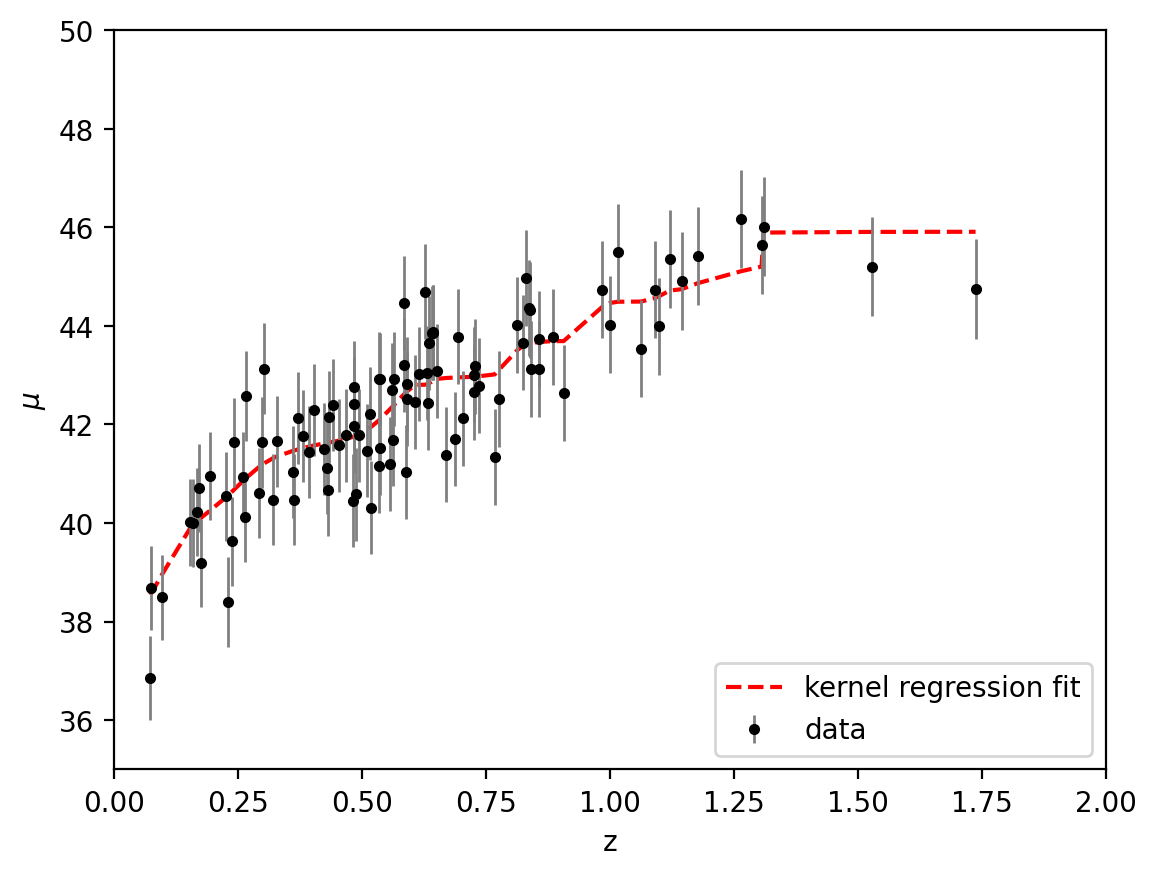

In [21]:
plt.plot(np.sort(z_sample), np.sort(y_pred_kernel), '--r', label = 'kernel regression fit')
plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1,label = 'data')
plt.xlabel("z")
plt.ylabel("$\mu$")
plt.legend(loc='lower right')
plt.xlim(0,2)
plt.ylim(35,50)